In [10]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.4'
spark_version = 'spark-3.5.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [11]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ReadParquet").getOrCreate()

In [12]:
from google.colab import drive
drive.mount('/content/drive')

# Load the Parquet file from Google Drive
file_path = "/content/drive/My Drive/TeamFiles/cleaned_data.parquet"
cleaned_df = spark.read.parquet(file_path)
cleaned_df.show(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+---+----------+----+-------------+----------+-----------------+-------------+---------------------------+----+-----+---+
|FSA|      DATE|HOUR|CUSTOMER_TYPE|PRICE_PLAN|TOTAL_CONSUMPTION|PREMISE_COUNT|AVG_CONSUMPTION_PER_PREMISE|YEAR|MONTH|DAY|
+---+----------+----+-------------+----------+-----------------+-------------+---------------------------+----+-----+---+
|M1V|2024-07-01|   1|    SGS <50kW|    Tiered|           3125.6|         1716|         1.8214452214452215|2024|    7|  1|
|L7M|2024-07-01|   1|    SGS <50kW|       TOU|           1563.8|          683|         2.2896046852122987|2024|    7|  1|
|L9W|2024-07-01|   1|  Residential|    Tiered|            925.0|         1232|         0.7508116883116883|2024|    7|  1|
|M2J|2024-07-01|   1|    SGS <50kW|    Tiered|            598.0|          267|         2.2397003745318353|2024|    7|  1|
|K2C|2024-07-01| 

In [13]:
#check the schema
cleaned_df.printSchema()

root
 |-- FSA: string (nullable = true)
 |-- DATE: date (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- CUSTOMER_TYPE: string (nullable = true)
 |-- PRICE_PLAN: string (nullable = true)
 |-- TOTAL_CONSUMPTION: double (nullable = true)
 |-- PREMISE_COUNT: integer (nullable = true)
 |-- AVG_CONSUMPTION_PER_PREMISE: double (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)



In [14]:
from pyspark.sql.functions import corr

# Correlation between TOTAL_CONSUMPTION and other numeric features
cleaned_df.select(
    corr("TOTAL_CONSUMPTION", "PREMISE_COUNT").alias("Consumption vs Premise Count"),
    corr("TOTAL_CONSUMPTION", "AVG_CONSUMPTION_PER_PREMISE").alias("Consumption vs Avg Consumption")
).show()


+----------------------------+------------------------------+
|Consumption vs Premise Count|Consumption vs Avg Consumption|
+----------------------------+------------------------------+
|           0.904197989725884|          -0.08181543115470465|
+----------------------------+------------------------------+



In [17]:
# Register the DataFrame as a SQL temporary view
cleaned_df.createOrReplaceTempView("cleaned_data")


In [19]:
# SQL query to calculate summary statistics for TOTAL_CONSUMPTION
result_1 = spark.sql("""
    SELECT
        MIN(TOTAL_CONSUMPTION) AS Min_Consumption,
        MAX(TOTAL_CONSUMPTION) AS Max_Consumption,
        AVG(TOTAL_CONSUMPTION) AS Avg_Consumption,
        STDDEV(TOTAL_CONSUMPTION) AS StdDev_Consumption
    FROM cleaned_data
""")

# Display the result
result_1.show()


+---------------+---------------+------------------+------------------+
|Min_Consumption|Max_Consumption|   Avg_Consumption|StdDev_Consumption|
+---------------+---------------+------------------+------------------+
|            0.4|       328766.1|3164.9492230510823| 6487.755698387407|
+---------------+---------------+------------------+------------------+



In [20]:
# SQL query to count the number of records grouped by CUSTOMER_TYPE
result_2 = spark.sql("""
    SELECT
        CUSTOMER_TYPE,
        COUNT(*) AS Record_Count
    FROM cleaned_data
    GROUP BY CUSTOMER_TYPE
    ORDER BY Record_Count DESC
""")

# Display the result
result_2.show()


+-------------+------------+
|CUSTOMER_TYPE|Record_Count|
+-------------+------------+
|  Residential|     2590139|
|    SGS <50kW|     1590315|
+-------------+------------+



+----------+--------------------+
|PRICE_PLAN|   Total_Consumption|
+----------+--------------------+
|       TOU|1.142482446370031...|
|    Tiered|1.2630378712999606E9|
|  Retailer| 5.209040018000014E8|
|       ULO|2.2158302500000034E7|
+----------+--------------------+



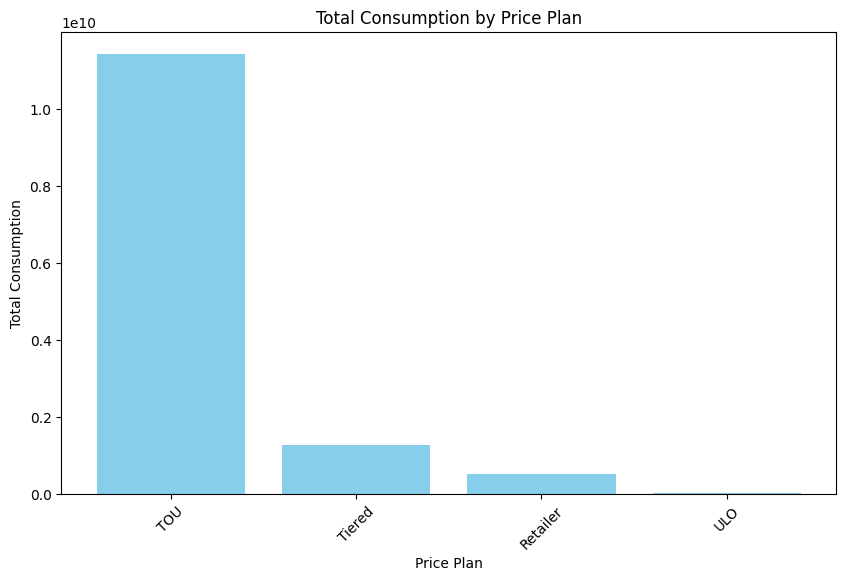

In [21]:
# SQL query to sum TOTAL_CONSUMPTION grouped by PRICE_PLAN
result_3 = spark.sql("""
    SELECT
        PRICE_PLAN,
        SUM(TOTAL_CONSUMPTION) AS Total_Consumption
    FROM cleaned_data
    GROUP BY PRICE_PLAN
    ORDER BY Total_Consumption DESC
""")

# Display the result
result_3.show()

# Visualization (Bar chart)
import matplotlib.pyplot as plt

# Collect query results for plotting
data = result_3.collect()
price_plans = [row["PRICE_PLAN"] for row in data]
total_consumptions = [row["Total_Consumption"] for row in data]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(price_plans, total_consumptions, color="skyblue")
plt.title("Total Consumption by Price Plan")
plt.xlabel("Price Plan")
plt.ylabel("Total Consumption")
plt.xticks(rotation=45)
plt.show()


+-------------+------------------+
|CUSTOMER_TYPE|   Avg_Consumption|
+-------------+------------------+
|    SGS <50kW|3.5043878643157207|
|  Residential|1.0285634768734695|
+-------------+------------------+



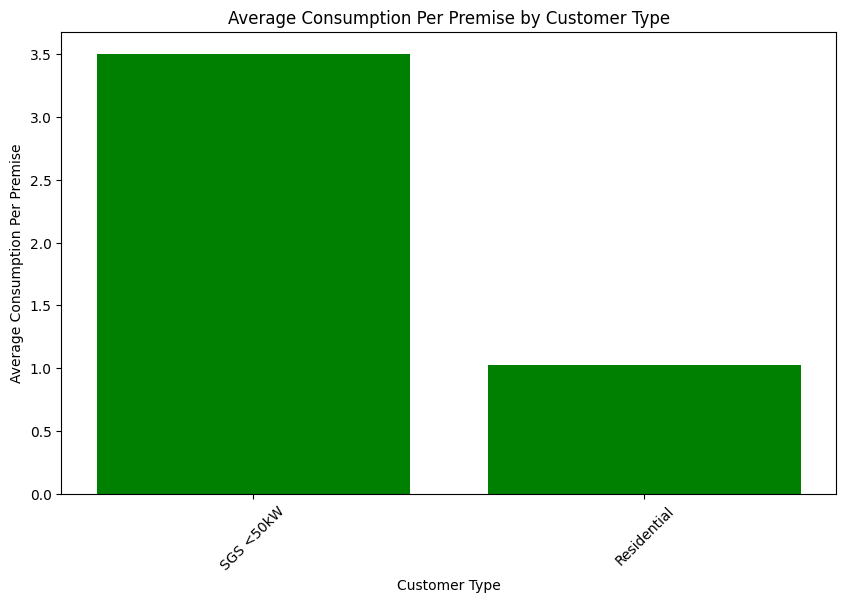

In [22]:
# SQL query to calculate average consumption per premise for each CUSTOMER_TYPE
result_4 = spark.sql("""
    SELECT
        CUSTOMER_TYPE,
        AVG(AVG_CONSUMPTION_PER_PREMISE) AS Avg_Consumption
    FROM cleaned_data
    GROUP BY CUSTOMER_TYPE
    ORDER BY Avg_Consumption DESC
""")

# Display the result
result_4.show()

# Visualization (Bar chart)
# Collect query results for plotting
data = result_4.collect()
customer_types = [row["CUSTOMER_TYPE"] for row in data]
avg_consumptions = [row["Avg_Consumption"] for row in data]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(customer_types, avg_consumptions, color="green")
plt.title("Average Consumption Per Premise by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Average Consumption Per Premise")
plt.xticks(rotation=45)
plt.show()


+----------+--------------------+
|      DATE|   Daily_Consumption|
+----------+--------------------+
|2024-04-01| 1.306135009999986E8|
|2024-04-02|1.3364014919999984E8|
|2024-04-03|1.3763896589999908E8|
|2024-04-04|1.4010338579999977E8|
|2024-04-05| 1.382504514999998E8|
|2024-04-06|1.3253077459999958E8|
|2024-04-07| 1.278725662000003E8|
|2024-04-08|1.2383743240000027E8|
|2024-04-09|1.1767297830000104E8|
|2024-04-10|1.1342947549999955E8|
|2024-04-11| 1.210748277999998E8|
|2024-04-12|1.2502703879999946E8|
|2024-04-13|1.3369126979999961E8|
|2024-04-14|1.2808154240000091E8|
|2024-04-15|1.1816901529999965E8|
|2024-04-16|1.1662494509999979E8|
|2024-04-17|1.2688261929999976E8|
|2024-04-18|1.2394356249999923E8|
|2024-04-19| 1.229742284000008E8|
|2024-04-20|1.3332417320000069E8|
+----------+--------------------+
only showing top 20 rows



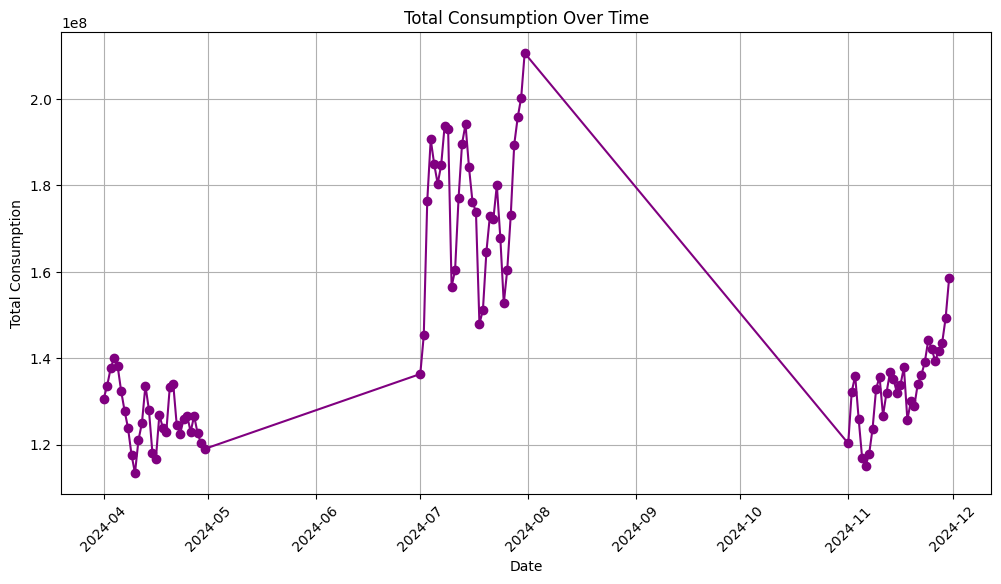

In [23]:
# SQL query to calculate daily total consumption
result_5 = spark.sql("""
    SELECT
        DATE,
        SUM(TOTAL_CONSUMPTION) AS Daily_Consumption
    FROM cleaned_data
    GROUP BY DATE
    ORDER BY DATE
""")

# Display the result
result_5.show()

# Visualization (Line chart)
# Collect query results for plotting
data = result_5.collect()
dates = [row["DATE"] for row in data]
daily_consumptions = [row["Daily_Consumption"] for row in data]

# Create the line chart
plt.figure(figsize=(12, 6))
plt.plot(dates, daily_consumptions, color="purple", marker="o")
plt.title("Total Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Total Consumption")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


+-----+-----------------------+
|MONTH|Avg_Monthly_Consumption|
+-----+-----------------------+
|    4|      2784.284010250972|
|    7|     3784.4333220329236|
|   11|     2896.1201670757446|
+-----+-----------------------+



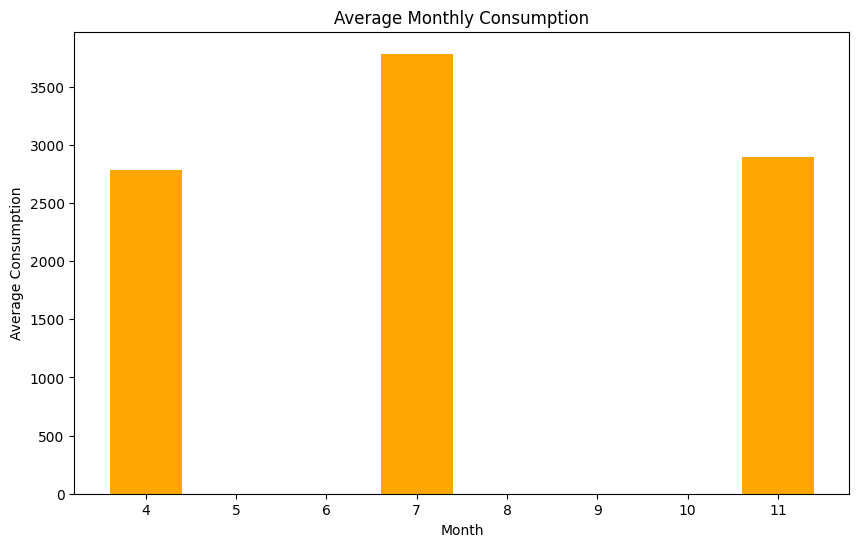

In [24]:
# SQL query to calculate monthly average consumption
result_6 = spark.sql("""
    SELECT
        MONTH,
        AVG(TOTAL_CONSUMPTION) AS Avg_Monthly_Consumption
    FROM cleaned_data
    GROUP BY MONTH
    ORDER BY MONTH
""")

# Display the result
result_6.show()

# Visualization (Bar chart)
# Collect query results for plotting
data = result_6.collect()
months = [row["MONTH"] for row in data]
avg_monthly_consumptions = [row["Avg_Monthly_Consumption"] for row in data]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(months, avg_monthly_consumptions, color="orange")
plt.title("Average Monthly Consumption")
plt.xlabel("Month")
plt.ylabel("Average Consumption")
plt.xticks(rotation=0)
plt.show()


+---+--------------------+
|FSA|   Total_Consumption|
+---+--------------------+
| L3| 1.963350712999995E8|
| L2|1.9387394350000045E8|
|K0K| 1.744444611000002E8|
|K0A|1.5150941259999973E8|
|N0B|1.3261266170000006E8|
| K9|1.2813028050000003E8|
|N0G|1.2214559329999964E8|
|K0L|1.1783542199999988E8|
| P0|1.1212862569999984E8|
|L0R|1.0869273860000002E8|
+---+--------------------+



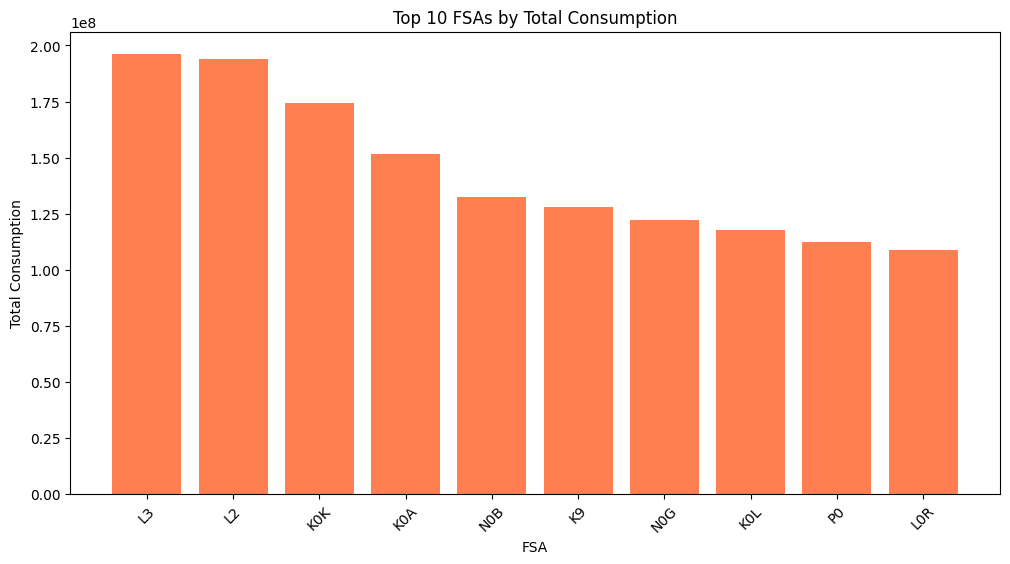

In [25]:
# SQL query to find the top 10 FSAs by total consumption
result_7 = spark.sql("""
    SELECT
        FSA,
        SUM(TOTAL_CONSUMPTION) AS Total_Consumption
    FROM cleaned_data
    GROUP BY FSA
    ORDER BY Total_Consumption DESC
    LIMIT 10
""")

# Display the result
result_7.show()

# Visualization (Bar chart)
# Collect query results for plotting
data = result_7.collect()
fsas = [row["FSA"] for row in data]
fsa_consumptions = [row["Total_Consumption"] for row in data]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(fsas, fsa_consumptions, color="coral")
plt.title("Top 10 FSAs by Total Consumption")
plt.xlabel("FSA")
plt.ylabel("Total Consumption")
plt.xticks(rotation=45)
plt.show()


+-------------+--------------------+
|CUSTOMER_TYPE|   Total_Consumption|
+-------------+--------------------+
|  Residential|1.1571201005999932E9|
|    SGS <50kW| 2.805881097000004E8|
+-------------+--------------------+



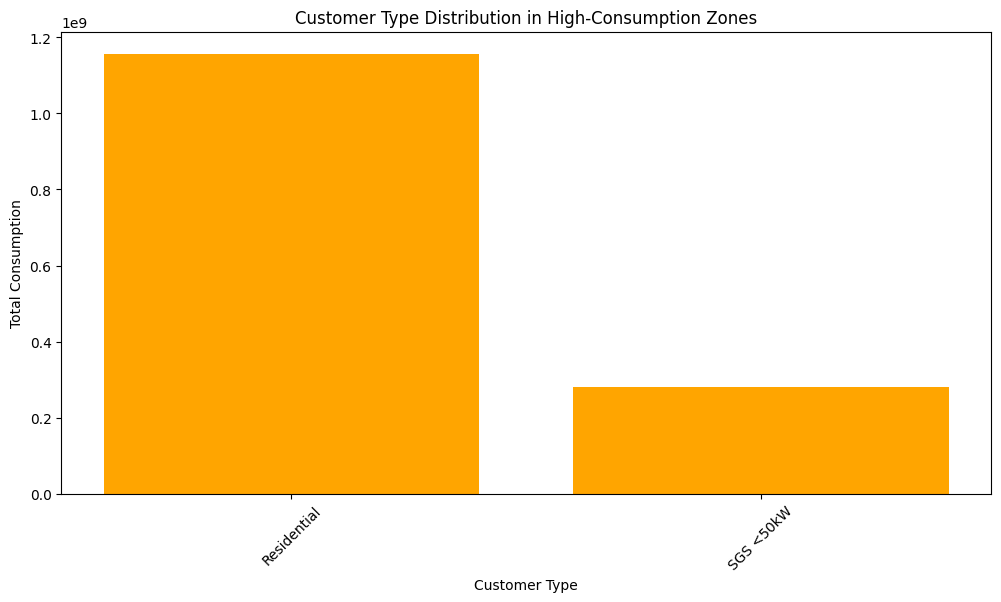

In [34]:
# To check What is the distribution of energy consumption by customer type in the top high-consumption zones
result = spark.sql("""
    SELECT
        CUSTOMER_TYPE,
        SUM(TOTAL_CONSUMPTION) AS Total_Consumption
    FROM cleaned_data
    WHERE FSA IN (
        SELECT FSA
        FROM (
            SELECT FSA, SUM(TOTAL_CONSUMPTION) AS Total_Consumption
            FROM cleaned_data
            GROUP BY FSA
            ORDER BY Total_Consumption DESC
            LIMIT 10
        )
    )
    GROUP BY CUSTOMER_TYPE
    ORDER BY Total_Consumption DESC
""")
result.show()

# Data Collection
customer_data = result.collect()
customer_types = [row["CUSTOMER_TYPE"] for row in customer_data]
total_consumptions = [row["Total_Consumption"] for row in customer_data]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(customer_types, total_consumptions, color="orange")
plt.title("Customer Type Distribution in High-Consumption Zones")
plt.xlabel("Customer Type")
plt.ylabel("Total Consumption")
plt.xticks(rotation=45)
plt.show()


In [26]:
# Analyze how different customer types contribute to July's high consumption
result_8 = spark.sql("""
    SELECT
        CUSTOMER_TYPE,
        SUM(TOTAL_CONSUMPTION) AS Total_Consumption
    FROM cleaned_data
    WHERE MONTH = 7
    GROUP BY CUSTOMER_TYPE
    ORDER BY Total_Consumption DESC
""")
result_8.show()


+-------------+--------------------+
|CUSTOMER_TYPE|   Total_Consumption|
+-------------+--------------------+
|  Residential| 4.394625677599994E9|
|    SGS <50kW|1.0418149692000228E9|
+-------------+--------------------+



In [28]:
# Compare total consumption in July with other months
result_9 = spark.sql("""
    SELECT
        MONTH,
        SUM(TOTAL_CONSUMPTION) AS Total_Consumption
    FROM cleaned_data
    GROUP BY MONTH
    ORDER BY Total_Consumption DESC
""")
result_9.show()


+-----+--------------------+
|MONTH|   Total_Consumption|
+-----+--------------------+
|    7|  5.43644064679999E9|
|   11| 4.003845585299878E9|
|    4|3.7906384072000937E9|
+-----+--------------------+



In [29]:
# Investigate which price plans are most common in July to see if a specific plan encourages higher usage
result_10 = spark.sql("""
    SELECT
        PRICE_PLAN,
        SUM(TOTAL_CONSUMPTION) AS Total_Consumption
    FROM cleaned_data
    WHERE MONTH = 7
    GROUP BY PRICE_PLAN
    ORDER BY Total_Consumption DESC
""")
result_10.show()



+----------+--------------------+
|PRICE_PLAN|   Total_Consumption|
+----------+--------------------+
|       TOU| 4.704905438700069E9|
|    Tiered| 5.193245566000079E8|
|  Retailer|2.0486490959999365E8|
|       ULO|   7345741.899999955|
+----------+--------------------+



+----------+--------------------+
|      DATE|   Daily_Consumption|
+----------+--------------------+
|2024-07-01| 1.363555793000002E8|
|2024-07-02|1.4526766859999916E8|
|2024-07-03| 1.763522081999986E8|
|2024-07-04| 1.906429272000001E8|
|2024-07-05|1.8488810690000156E8|
|2024-07-06|       1.803764142E8|
|2024-07-07|1.8467123689999878E8|
|2024-07-08|1.9381518560000074E8|
|2024-07-09|1.9304292259999886E8|
|2024-07-10|1.5658113850000104E8|
|2024-07-11| 1.603533689999997E8|
|2024-07-12|1.7701244110000032E8|
|2024-07-13|1.8962472430000117E8|
|2024-07-14|1.9412856229999864E8|
|2024-07-15|1.8415435069999945E8|
|2024-07-16|1.7623106380000123E8|
|2024-07-17|1.7385772449999908E8|
|2024-07-18|1.4796234649999812E8|
|2024-07-19| 1.511439549999983E8|
|2024-07-20|1.6459236280000028E8|
+----------+--------------------+
only showing top 20 rows



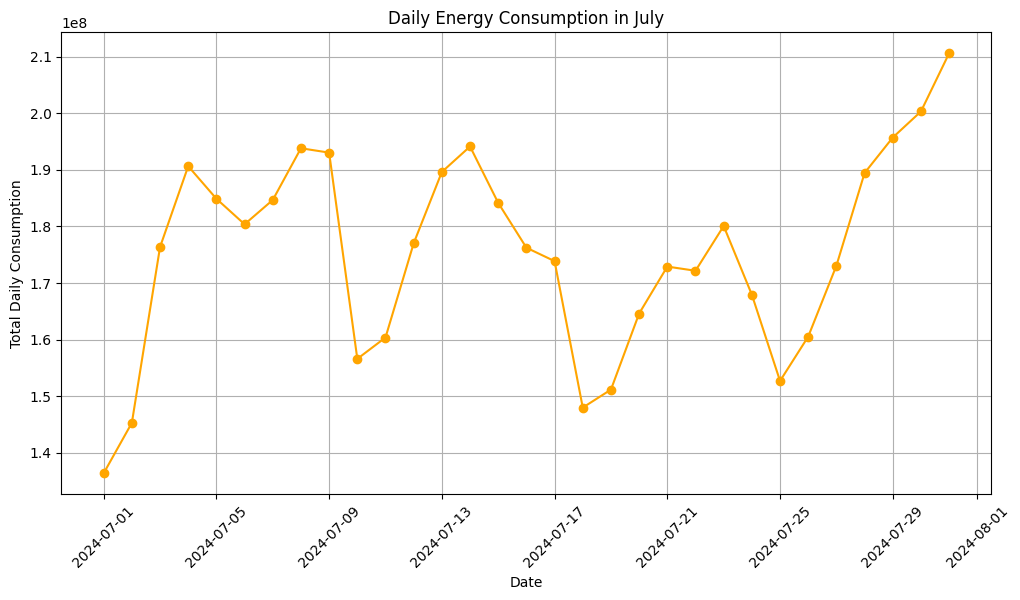

In [31]:
# Look at daily consumption trends for July to identify specific peak days
result_11 = spark.sql("""
    SELECT
        DATE,
        SUM(TOTAL_CONSUMPTION) AS Daily_Consumption
    FROM cleaned_data
    WHERE MONTH = 7
    GROUP BY DATE
    ORDER BY DATE
""")
result_11.show()

# Collect the query results for plotting
data = result_11.collect()
dates = [row["DATE"] for row in data]  # Extract the dates
daily_consumptions = [row["Daily_Consumption"] for row in data]  # Extract the daily consumption

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates, daily_consumptions, marker="o", linestyle="-", color="orange")
plt.title("Daily Energy Consumption in July")
plt.xlabel("Date")
plt.ylabel("Total Daily Consumption")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
